#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import nltk
import re
import matplotlib.pyplot as plt
# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

import nltk
import nltk.corpus
import string
from gensim.models.word2vec import Word2Vec
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

In [2]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [3]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

#Import Dataset

In [4]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Saving valid.csv to valid (1).csv


In [5]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [11]:
# Shape of each set

print("Shape of TRAIN DATA: ", train.shape)
print("Shape of TEST DATA: ", test.shape)
print("Shape of VALID DATA: ", valid.shape)

Shape of TRAIN DATA:  (10240, 2)
Shape of TEST DATA:  (2551, 2)
Shape of VALID DATA:  (2571, 2)


# Sentiment Analysis

Get polarity and subjectivity scores of the news with TextBlob

In [6]:
# Import the TextBlob
from textblob import TextBlob

In [7]:
# Add polarities and subkectivities into the DataFrame by using TextBlob
train["Polarity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.polarity)
train["Subjectivity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

test["Polarity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.polarity)
test["Subjectivity"] = train["Statement"].apply(lambda word: TextBlob(word).sentiment.subjectivity)


# Display the Polarity and Subjectivity columns of train dataset
display(train[["Statement","Polarity","Subjectivity"]].head(10))

,Statement,Polarity,Subjectivity
0,Says the Annies List political group supports ...,0.000000,0.100000
1,When did the decline of coal start? It started...,0.100000,0.400000
2,"Hillary Clinton agrees with John McCain ""by vo...",0.000000,0.000000
3,Health care reform legislation is likely to ma...,0.200000,0.900000
4,The economic turnaround started at the end of ...,0.200000,0.200000
5,The Chicago Bears have had more starting quart...,0.100000,0.296667
6,Jim Dunnam has not lived in the district he re...,0.000000,0.000000
7,I'm the only person on this stage who has work...,-0.044444,0.555556
8,"However, it took $19.5 million in Oregon Lotte...",0.136364,0.454545
9,Says GOP primary opponents Glenn Grothman and ...,0.325000,0.500000


In [14]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
train["SentLabel"] = train["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(train[["SentLabel"]].head(10))

,SentLabel
0,Neutral
1,Positive
2,Neutral
3,Positive
4,Positive
5,Positive
6,Neutral
7,Negative
8,Positive
9,Positive


In [ ]:
# Print the value counts of the SentLabel column
print(train["SentLabel"].value_counts())

Neutral     4635
Positive    3677
Negative    1928
Name: SentLabel, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


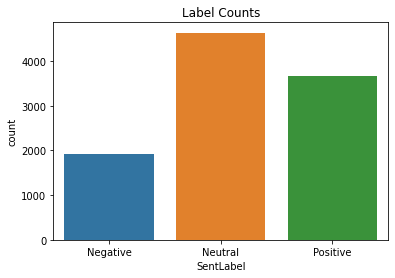

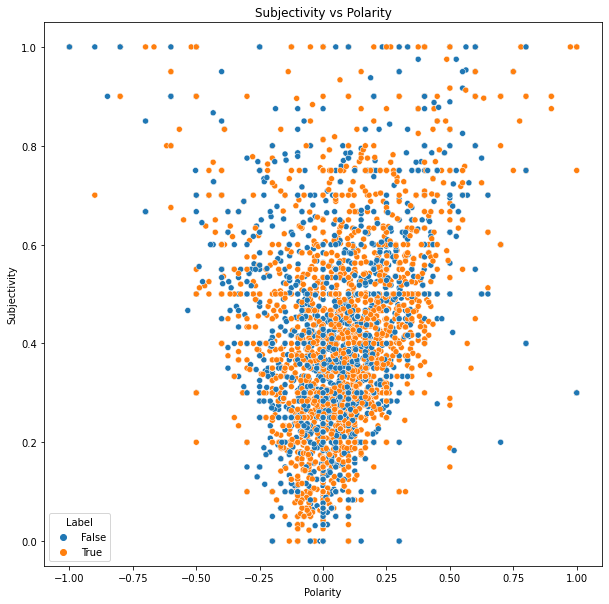

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Change the datatype as "category"
train["SentLabel"] = train["SentLabel"].astype("category")

# Visualize the Label counts
sns.countplot(train["SentLabel"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=train)
plt.title("Subjectivity vs Polarity")
plt.show()

#Pre-processing

In [36]:
# transform labels

def transformLabel(newLabels):
  labels = newLabels.copy()
  for i in range(len(labels)):
    if labels[i] == 'false':
      labels[i] = 0.0
    elif labels[i] == 'true':
      labels[i] = 1.0
  labels = np.asarray(labels).astype('float32')
  return labels

In [8]:
def rem_noise(text):
  text = text.translate(str.maketrans('','',string.punctuation))

  text =  re.sub('[0-9]+','',text)

  text = re.sub('https?:\S+','',text)

  text =  re.sub('<.*?>'," ",text)

  return text

In [9]:
stop = set(stopwords.words('english'))

def rem_stopwords(text):
    
    words = [ch for ch in text if ch not in stop]
    words= "".join(words).split()
    words= [words.lower() for words in text.split()]
    
    return words

In [10]:
def tokenize_statements(text):
    
    # Tokenize the words
    tokenized = word_tokenize(text)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words, changing text to lowercase
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token.lower(), pos='a') for token in tokenized]
    
    return tokenized

In [11]:
X_train = train["Statement"]
X_test = test["Statement"]
y_train = train["Label"]
y_test = test["Label"]

x_train_pol = train["Polarity"]
x_test_pol = test["Polarity"]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

x_train_pol.shape

(10240,)
(10240,)
(2551,)
(2551,)


(10240,)

In [ ]:
print (x_train_pol)

0        0.000000
1        0.100000
2        0.000000
3        0.200000
4        0.200000
           ...   
10235    0.000000
10236    0.000000
10237    0.191667
10238    0.000000
10239    0.200000
Name: Polarity, Length: 10240, dtype: float64


In [19]:
# Vectorize the text so the models can actually interpret it
vectorizer = TfidfVectorizer(tokenize_statements)
x_train_vectorized = vectorizer.fit_transform(X_train)
x_test_vectorized = vectorizer.transform(X_test)

In [20]:
print (x_train_vectorized.shape)
print (x_test_vectorized.shape)
print (y_train.shape)
print (y_test.shape)
print (x_test_pol.shape)



(10240, 12196)
(2551, 12196)
(10240,)
(2551,)
(2551,)


In [21]:
df_x_test_tfidf =  pd.DataFrame.sparse.from_spmatrix(x_test_vectorized)
df_x_test_tfidf['polarity'] = test['Polarity'].values

df_x_train_tfidf =  pd.DataFrame.sparse.from_spmatrix(x_train_vectorized)
df_x_train_tfidf['polarity'] = train['Polarity'].values

In [22]:
df_x_train_tfidf_nopol = df_x_train_tfidf.drop(['polarity'],axis=1)
df_x_test_tfidf_nopol = df_x_test_tfidf.drop(['polarity'],axis=1)

# Logistic Regression

In [23]:
log_reg = LogisticRegression()
log_reg.fit(df_x_train_tfidf, y_train)
logR_predicted = log_reg.predict(df_x_test_tfidf)
print(f"{log_reg.__class__.__name__} accuracy: {log_reg.score(df_x_test_tfidf, y_test)}")

LogisticRegression accuracy: 0.6158369266954136


In [ ]:
log_reg_nopol = LogisticRegression()
log_reg_nopol.fit(df_x_train_tfidf_nopol, y_train)
logR_predicted = log_reg_nopol.predict(df_x_test_tfidf_nopol)
print(f"{log_reg_nopol.__class__.__name__} accuracy: {log_reg_nopol.score(df_x_test_tfidf_nopol, y_test)}")

In [ ]:
print(classification_report(y_test, logR_predicted))
print('\n')
print(confusion_matrix(y_test, logR_predicted))

In [ ]:
cv_results = cross_validate(log_reg, df_x_train_tfidf, y_train, cv=2)
cv_results['test_score'].mean()

#Random Forest

In [25]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest.fit(df_x_train_tfidf, y_train)

print(f"{random_forest.__class__.__name__} accuracy: {random_forest.score(df_x_test_tfidf, y_test)}")

RandomForestClassifier accuracy: 0.5793806350450803


In [ ]:
random_forest_nopol = RandomForestClassifier(n_estimators=10, max_depth=100)
random_forest_nopol.fit(df_x_train_tfidf_nopol, y_train)

print(f"{random_forest_nopol.__class__.__name__} accuracy: {random_forest_nopol.score(df_x_test_tfidf_nopol, y_test)}")

In [ ]:
rForest_pred = random_forest.predict(df_x_test_tfidf)
print(classification_report(y_test, rForest_pred))
print('\n')
print(confusion_matrix(y_test, rForest_pred))

In [ ]:
cv_results = cross_validate(random_forest, df_x_train_tfidf, y_train, cv=5)
cv_results['test_score'].mean()

#SVM

In [ ]:
svm = LinearSVC()
svm.fit(df_x_train_tfidf, y_train)
print(f"{svm.__class__.__name__} accuracy: {svm.score(df_x_test_tfidf, y_test)}")

In [ ]:
svm_nopol = LinearSVC()
svm_nopol.fit(df_x_train_tfidf_nopol, y_train)
print(f"{svm_nopol.__class__.__name__} accuracy: {svm_nopol.score(df_x_test_tfidf_nopol, y_test)}")

In [ ]:
svm_pred = svm.predict(df_x_test_tfidf)

print(classification_report(y_test, svm_pred))
print('\n')
print(confusion_matrix(y_test, svm_pred))

In [ ]:
cv_results = cross_validate(svm, df_x_train_tfidf, y_train, cv=5)
cv_results['test_score'].mean()

#GoVe LSTM

In [46]:
df_lstm_all = pd.concat([train,test])

In [47]:
df_lstm_all

,Statement,Label,Polarity,Subjectivity
0,Says the Annies List political group supports ...,False,0.00000,0.10000
1,When did the decline of coal start? It started...,True,0.10000,0.40000
2,"Hillary Clinton agrees with John McCain ""by vo...",True,0.00000,0.00000
3,Health care reform legislation is likely to ma...,False,0.20000,0.90000
4,The economic turnaround started at the end of ...,True,0.20000,0.20000
...,...,...,...,...
2546,"For the first time in more than a decade, impo...",True,-0.10000,0.05000
2547,Says Donald Trump has bankrupted his companies...,True,0.25000,0.56250
2548,"John McCain and George Bush have ""absolutely n...",True,0.00000,0.30000
2549,A new poll shows 62 percent support the presid...,False,-0.04375,0.25625


In [48]:
glovedf = df_lstm_all.reset_index(drop=True)

In [49]:
cleantext = glovedf['Statement'].apply(rem_noise)
cleantext = cleantext.apply(rem_stopwords)
y_transformed = transformLabel(glovedf['Label'])

In [50]:
y_transformed

array([0., 1., 1., ..., 1., 0., 0.], dtype=float32)

In [52]:
x = cleantext.values
y = y_transformed

In [53]:
from keras.preprocessing import text, sequence

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
word_to_index = tokenizer.word_index
contentSequence = tokenizer.texts_to_sequences(x)

In [56]:
vocab_size =  len(word_to_index)
oov_tok = "<OOV>"
max_length = 250
embedding_dim = 100

In [57]:
from keras.preprocessing.sequence import pad_sequences

contentSequence = pad_sequences(contentSequence, maxlen=max_length)

In [58]:
contentSequence

array([[   0,    0,    0, ...,  532,   11, 1668],
       [   0,    0,    0, ...,  621, 1051,  168],
       [   0,    0,    0, ..., 3820,   11,  369],
       ...,
       [   0,    0,    0, ..., 1399,   30,   40],
       [   0,    0,    0, ...,   30,  115,   90],
       [   0,    0,    0, ..., 2164,   10, 7440]], dtype=int32)

#Glove Embedding

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# load the whole embedding into memory

embeddings_index = {};
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

# create a weight matrix for words

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [63]:
df_lstm =  pd.DataFrame(contentSequence)
#df_lstm['polarity'] = smallerdf['Polarity'].values

In [64]:
df_lstm.shape

(12791, 250)

In [65]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_lstm,y,test_size=0.20,random_state=1)

#Defining Neural Network

In [66]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size+1, output_dim=embedding_dim, weights=[embeddings_matrix], input_length=max_length, trainable=False))
#LSTM 
model.add(LSTM(units=128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test,y_test) , epochs=5)

In [ ]:
y_pred_glove = (model.predict(X_test) > 0.5).astype("int")

In [ ]:
print(classification_report(y_test, y_pred_glove, zero_division = 1))

In [ ]:
#plot accuracy and loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")